# Excluding Race

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

#loading data
data = pd.read_csv('/Users/yunjuha/Desktop/ML-DXA-BIS/Data Files/ML-DXA-BIS_Combined_Data.csv')
df = pd.DataFrame(data)

#TRANSFORMING THE TARGETS
df['tjumppownums'] = np.log(df['jumppownums'] + 0.1)
df['tCOMB4IMaxGrip'] = np.sqrt(df['COMB4IMaxGrip'])

#dropping columns
column_to_drop = ['M2ID', 'MIDUSID', 'SAMPLMAJ', 'Height.cm.', 'Weight.kg.', 'Age.years.', 'TBW.litres.', 'ECF.litres.', 'ICF.litres.']
df = df.drop(column_to_drop, axis=1)

df = df.drop('COMB1PF7A', axis=1)

In [11]:
#number of individuals before NA is removed
print(len(df))

544


In [12]:
#this is the total number of people when race is removed
df = df.dropna()
print(len(df))

490


# Random Forest

In [13]:
#RF Function

def train_test_random_forest(df, feature_columns, target_column, remove_by=40, test_size=0.2, random_state=42):
    original_size = len(df)
    r_squared_data = []

    while len(df) >= remove_by:        
        columns = feature_columns + [target_column]
        X = df[columns]
        y = X.pop(target_column)
        
        #dividing into train and test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        #our hyperparameter grid for random forest
        param_grid = {
            'n_estimators': [5, 10, 20],
            'max_depth': [None, 1, 2, 4, 8, 16],
            'min_samples_split': [1, 2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': [1, 2, 4, 8, X_train.shape[1]]
        }

        rf_model = RandomForestRegressor(random_state=42)

        #doing gridsearch to find best hyperparameters
        grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_rf_model = grid_search.best_estimator_

        y_pred = best_rf_model.predict(X_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        #print("Best parameters:", best_params)
        #print("Mean Squared Error:", mse)

        #fitting with BEST HYPERPARAMETERS
        rf = RandomForestRegressor(
            max_depth=best_params['max_depth'],
            min_samples_leaf=best_params['min_samples_leaf'],
            min_samples_split=best_params['min_samples_split'],
            n_estimators=best_params['n_estimators'],
            max_features=best_params['max_features'],
            random_state=42
        )
        rf.fit(X_train, y_train)

        #TRAINING
        y_train_pred = rf.predict(X_train)
        r2_train = metrics.r2_score(y_train, y_train_pred)

        #TESTING
        y_test_pred = rf.predict(X_test)
        r2_test = metrics.r2_score(y_test, y_test_pred)

        r_squared_data.append({'Number of Individuals': len(df), 'Training R-squared': r2_train, 'Testing R-squared': r2_test})

        #removing 40 individuals for the next iteration
        indices_to_remove = df.sample(n=remove_by, random_state=random_state).index
        df = df.drop(indices_to_remove)

    #table of R-squared values
    r_squared_table = pd.DataFrame(r_squared_data)
    print("\nR-squared Values:")
    print(r_squared_table)

    #plot
    plt.figure(figsize=(10, 6))
    plt.plot(r_squared_table['Number of Individuals'], r_squared_table['Training R-squared'], label='Training R-squared')
    plt.plot(r_squared_table['Number of Individuals'], r_squared_table['Testing R-squared'], label='Testing R-squared')
    plt.xlabel('Number of Individuals')
    plt.ylabel('R-squared')
    plt.title('Training and Testing R-squared vs Number of Individuals')
    plt.legend()
    plt.show()

## DXA: Handgrip Strength (ARMS)

Random Forest: DXA Model, Handgrip Strength (Arms)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.800352           0.353933
1                     450            0.748022           0.370996
2                     410            0.827977           0.476953
3                     370            0.819821           0.620789
4                     330            0.795949           0.505672
5                     290            0.788236           0.526108
6                     250            0.686528           0.361629
7                     210            0.572280           0.534606
8                     170            0.778020           0.225929
9                     130            0.791329           0.127432
10                     90            0.739020           0.385686
11                     50            0.676857           0.192505


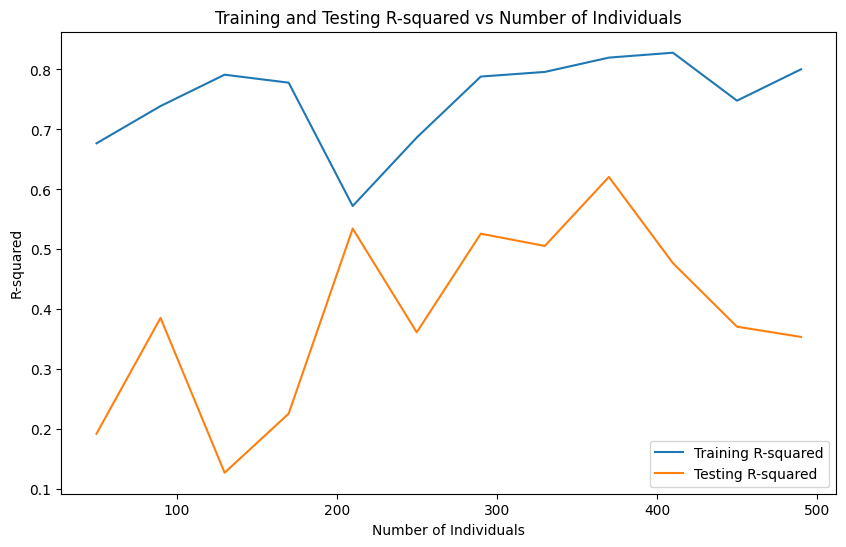

In [14]:
print("Random Forest: DXA Model, Handgrip Strength (Arms)")

train_test_random_forest(df, ['COMB4DALM', 'COMB4DABM', 'COMB4DAFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD'], 'tCOMB4IMaxGrip')

## DXA: Handgrip Strength (TOTAL BODY)

Random Forest: DXA Model, Handgrip Strength (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.620096           0.413156
1                     450            0.787752           0.392589
2                     410            0.610073           0.496424
3                     370            0.686061           0.521286
4                     330            0.773586           0.419889
5                     290            0.627178           0.475703
6                     250            0.700928           0.337644
7                     210            0.690962           0.422766
8                     170            0.724803           0.098958
9                     130            0.836248           0.396836
10                     90            0.577934           0.251585
11                     50            0.743068           0.317246


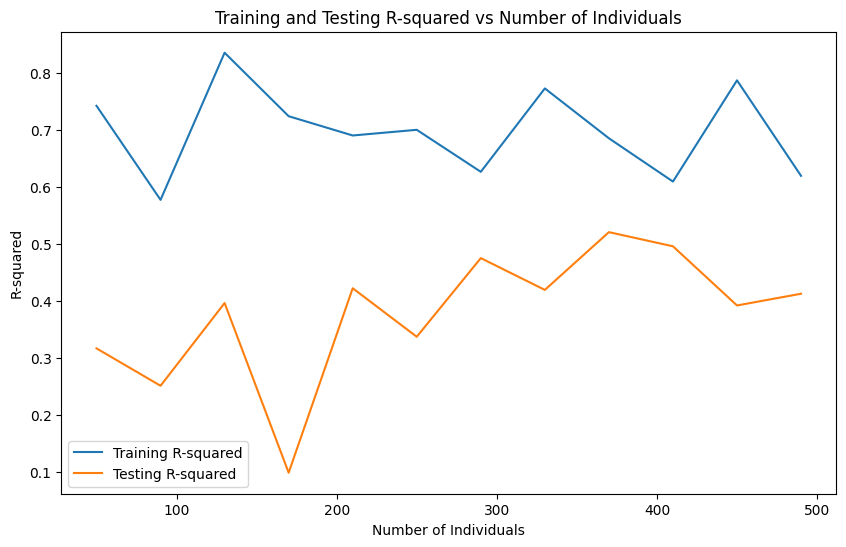

In [15]:
print("Random Forest: DXA Model, Handgrip Strength (TB)")

train_test_random_forest(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD'], 'tCOMB4IMaxGrip')

## DXA: Jump Power (LEGS)

Random Forest: DXA Model, Jump Power (Legs)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.935910           0.730516
1                     450            0.907951           0.461933
2                     410            0.929149           0.566660
3                     370            0.886762           0.789169
4                     330            0.816852           0.802317
5                     290            0.922326           0.595110
6                     250            0.815635           0.660305
7                     210            0.869770           0.482601
8                     170            0.887468           0.730718
9                     130            0.948137           0.634394
10                     90            0.866809           0.655088
11                     50            0.751936          -0.010834


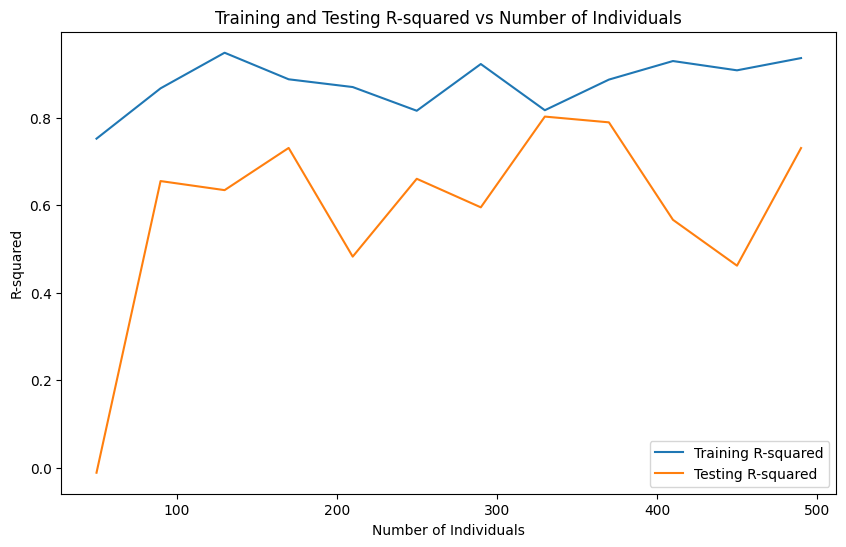

In [16]:
print("Random Forest: DXA Model, Jump Power (Legs)")

train_test_random_forest(df, ['COMB4ILLM', 'COMB4DLBM', 'COMB4DLFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLFNMD'], 'tjumppownums')

## DXA: Jump Power (TOTAL BODY)

Random Forest: DXA Model, Jump Power (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.873446           0.733295
1                     450            0.877842           0.539761
2                     410            0.887639           0.607350
3                     370            0.943577           0.704522
4                     330            0.813524           0.836928
5                     290            0.861739           0.613142
6                     250            0.941360           0.747826
7                     210            0.871737           0.486165
8                     170            0.943374           0.773799
9                     130            0.922727           0.624944
10                     90            0.951191           0.752236
11                     50            0.805378           0.477791


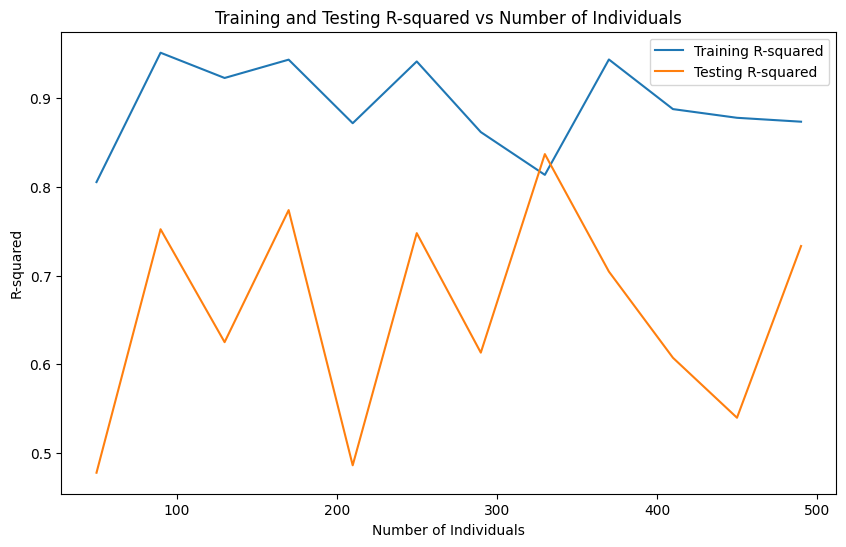

In [17]:
print("Random Forest: DXA Model, Jump Power (TB)")

train_test_random_forest(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD'], 'tjumppownums')

## BIS: Handgrip Strength

Random Forest: BIS Model, Handgrip Strength


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.620608           0.388693
1                     450            0.666905           0.429912
2                     410            0.916370           0.450061
3                     370            0.816935           0.487114
4                     330            0.625440           0.462974
5                     290            0.671585           0.442318
6                     250            0.567554           0.379325
7                     210            0.870883           0.251572
8                     170            0.879923           0.224026
9                     130            0.720666           0.446051
10                     90            0.682428           0.428976
11                     50            0.496219          -0.212926


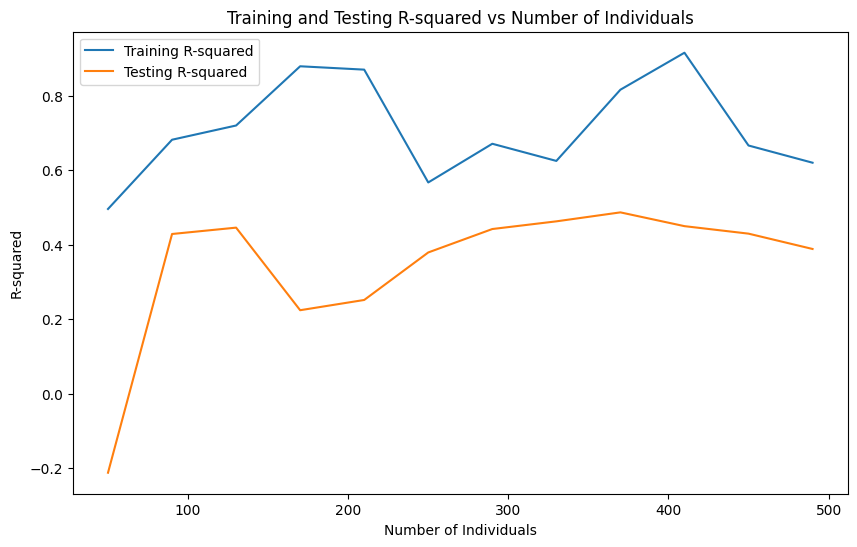

In [18]:
print("Random Forest: BIS Model, Handgrip Strength")

train_test_random_forest(df, ['COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A'], 'tCOMB4IMaxGrip')

## BIS: Jump Power

Random Forest: BIS Model, Jump Power


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.909763           0.713035
1                     450            0.849690           0.499790
2                     410            0.930358           0.593495
3                     370            0.906132           0.750148
4                     330            0.887595           0.737334
5                     290            0.890119           0.598398
6                     250            0.898189           0.676673
7                     210            0.909918           0.583891
8                     170            0.790000           0.663159
9                     130            0.849202           0.520989
10                     90            0.917607           0.542286
11                     50            0.683588           0.608831


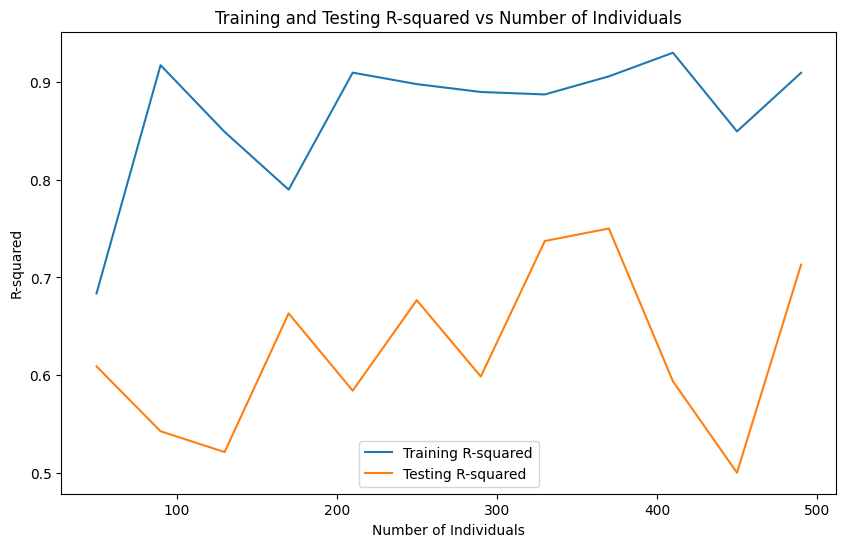

In [19]:
print("Random Forest: BIS Model, Jump Power")

train_test_random_forest(df, ['COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A'], 'tjumppownums')

## COMBO: Handgrip Strength (ARMS)

Random Forest: Combo Models, Handgrip Strength (Arms)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.595450           0.389572
1                     450            0.723696           0.395026
2                     410            0.696453           0.479253
3                     370            0.616818           0.552795
4                     330            0.775912           0.473635
5                     290            0.739242           0.515751
6                     250            0.669036           0.436186
7                     210            0.764621           0.409724
8                     170            0.861612           0.157203
9                     130            0.750654           0.376262
10                     90            0.909897           0.407805
11                     50            0.880205           0.282313


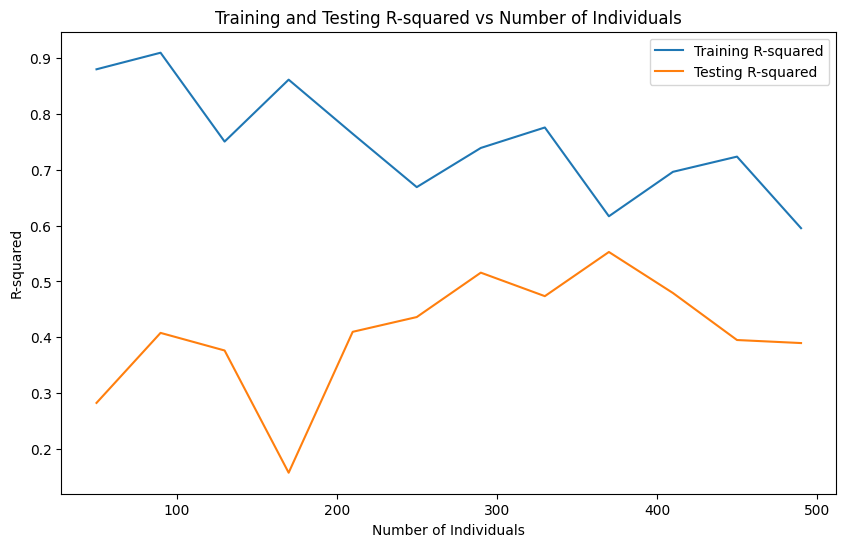

In [20]:
print("Random Forest: Combo Models, Handgrip Strength (Arms)")

train_test_random_forest(df, ['COMB4DALM', 'COMB4DABM', 'COMB4DAFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tCOMB4IMaxGrip')

## COMBO: Handgrip Strength (TOTAL BODY)

Random Forest: Combo Models, Handgrip Strength (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.854144           0.305692
1                     450            0.660582           0.392579
2                     410            0.737300           0.408560
3                     370            0.779876           0.562704
4                     330            0.872763           0.468746
5                     290            0.593476           0.485809
6                     250            0.713762           0.353967
7                     210            0.787237           0.389336
8                     170            0.876862           0.152944
9                     130            0.744205           0.435792
10                     90            0.852334           0.190030
11                     50            0.753888          -0.127929


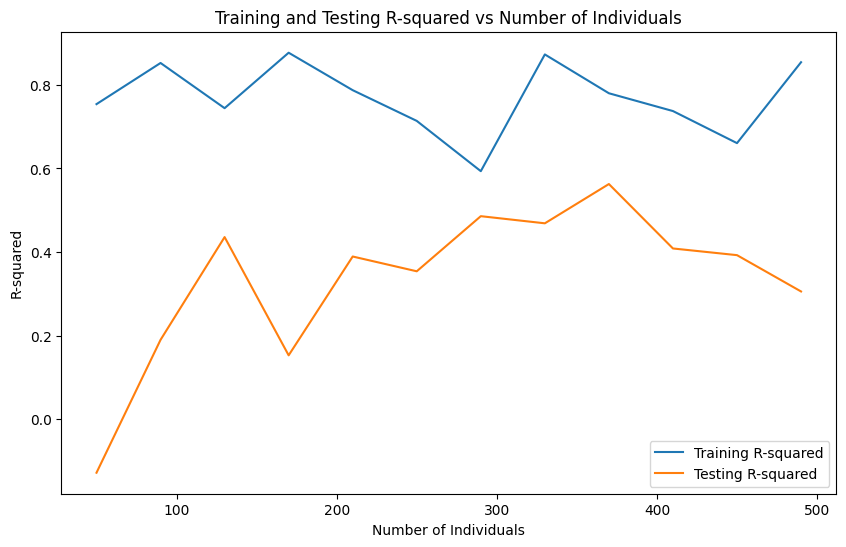

In [21]:
print("Random Forest: Combo Models, Handgrip Strength (TB)")

train_test_random_forest(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD', 'COMB4IMECF', 'COMB4IMICF','COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tCOMB4IMaxGrip')

## COMBO: Jump Power (LEGS)

Random Forest: Combo Models, Jump Power (Legs)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.895793           0.745937
1                     450            0.927565           0.601277
2                     410            0.866288           0.613602
3                     370            0.912367           0.736271
4                     330            0.895181           0.770723
5                     290            0.932433           0.609101
6                     250            0.858509           0.645787
7                     210            0.916378           0.572484
8                     170            0.942965           0.753760
9                     130            0.917855           0.628849
10                     90            0.723608           0.666546
11                     50            0.887466           0.785214


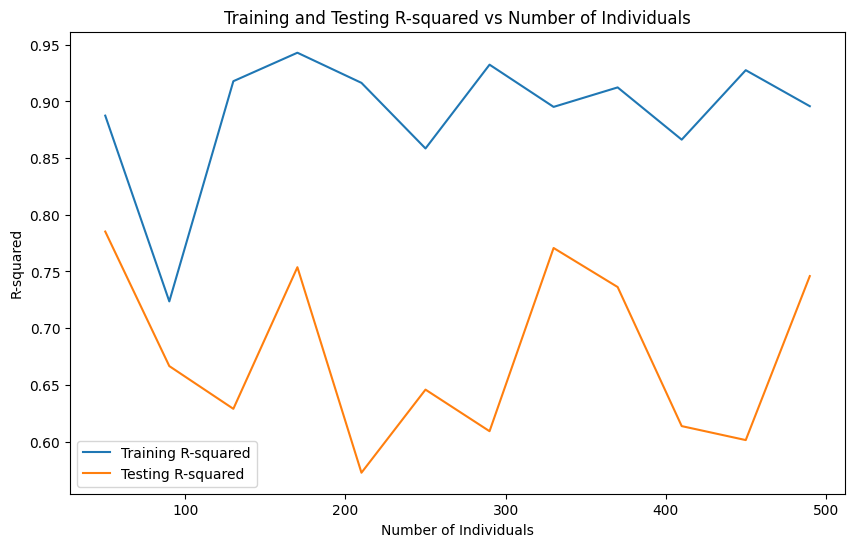

In [22]:
print("Random Forest: Combo Models, Jump Power (Legs)")

train_test_random_forest(df, ['COMB4ILLM', 'COMB4DLBM', 'COMB4DLFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLFNMD', 'COMB4IMECF', 'COMB4IMICF', 'COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tjumppownums')

## COMBO: Jump Power (TOTAL BODY)

Random Forest: Combo Models, Jump Power (TB)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python


R-squared Values:
    Number of Individuals  Training R-squared  Testing R-squared
0                     490            0.911247           0.761558
1                     450            0.934763           0.583633
2                     410            0.871501           0.619281
3                     370            0.932815           0.690931
4                     330            0.904657           0.799292
5                     290            0.941713           0.634062
6                     250            0.916761           0.631492
7                     210            0.899428           0.535203
8                     170            0.854652           0.764690
9                     130            0.955766           0.551022
10                     90            0.864126           0.781814
11                     50            0.919350           0.701203


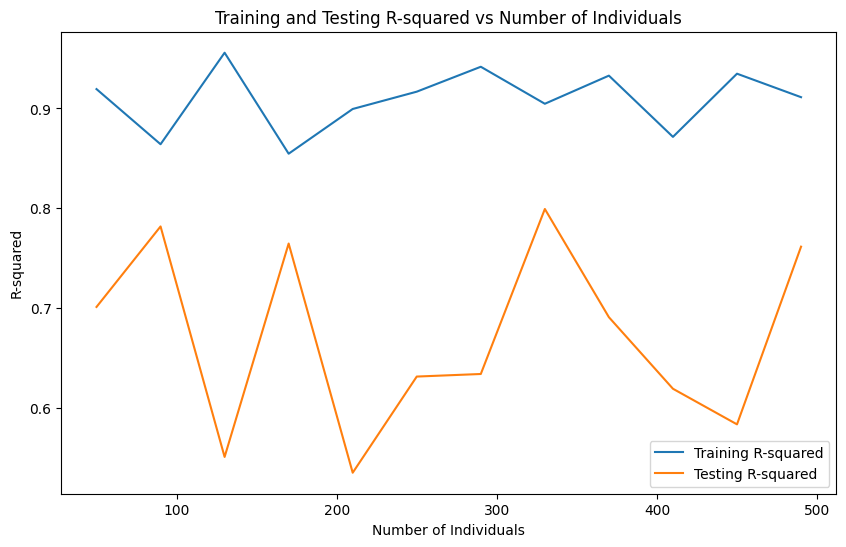

In [23]:
print("Random Forest: Combo Models, Jump Power (TB)")

train_test_random_forest(df, ['COMB4IALM', 'COMB4DTBBM', 'COMB4DTBFM', 'COMB1PRSEX', 'COMB1PRAGE', 'COMB4P1A', 'COMB4DLR3MD', 'COMB4DLFNMD', 'COMB4DLSL14MD', 'COMB4IMECF', 'COMB4IMICF','COMB4IMFFM', 'COMB4DTBFM', 'COMB4IRES0', 'COMB4IRESINF', 'COMB4IRESEXC', 'COMB4IRESINC', 'COMB4IFCHAR', 'COMB4IMCAP'], 'tjumppownums')